In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
plt.rcParams["figure.figsize"] = 10, 8
plt.rcParams["font.size"     ] = 14



In [2]:
import numpy as np
import pandas as pd
from collections import namedtuple
import os
import glob

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms

In [4]:
from pymono.config import CsI_6x6_sidewrap_50k_2MHzDC_PTFE_LUT_fano_NX

In [5]:
from pymono.aux_func import select_image_files, select_image_and_metadata, energy
from pymono.aux_func import select_image_and_lbl, get_energy, get_means_stds
from pymono.aux_func import mean_rms, weighted_mean_and_sigma, energy_h3d, corrected_energy

In [6]:
from pymono.plt_funcs import plot_true_positions, plot_images, plot_energies, plot_corrected_energy
from pymono.plt_funcs import  plot_true_predicted, plotxyz, plot_h3d, plot_energies2, plot_loss
from pymono.plt_funcs import plot_images_ds, histoplot, plot_image_ds, plot_images_ds, plot_image

In [7]:
from pymono.cnn_func import single_run, CNN_basic, CNN_3x3,train_cnn, evaluate_cnn

In [8]:
from pymono.cnn_func import ResNet10

In [9]:
from pymono.mono_dl import MonoDataset, files_list_npy_csv,mono_data_loader

In [10]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


# CsITl_6x6_sidewrap_25k_2MHzDC_PTFE_LUT_NX

- Study performance of a CsITl monolithic crystal (all but entry side reflectant, entry side black).
- Compare Conv and Resnet

#### Parameters
- 6x6 SiPMs, thus 8x8 matrix
- 25 k photons per point (CsI(Tl), with ~50 k photons/MeV)
- 2MHzDC (Warm CsI-TL)
- PTFE wrapping (all sides but entry face)
- LUT model
- Nexus simulation 

## Setup

In [11]:
crystal = CsITl_6x6_sidewrap_25k_2MHzDC_PTFE_LUT_NX

In [12]:
imgs, mdata = select_image_and_lbl(crystal, 9)

Selected files: img = images_9.npy, metdata = metadata_9.csv


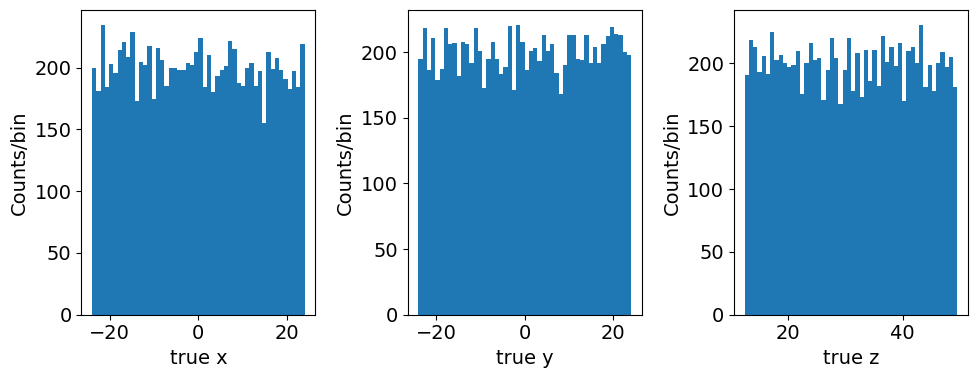

In [13]:
plot_true_positions(mdata)

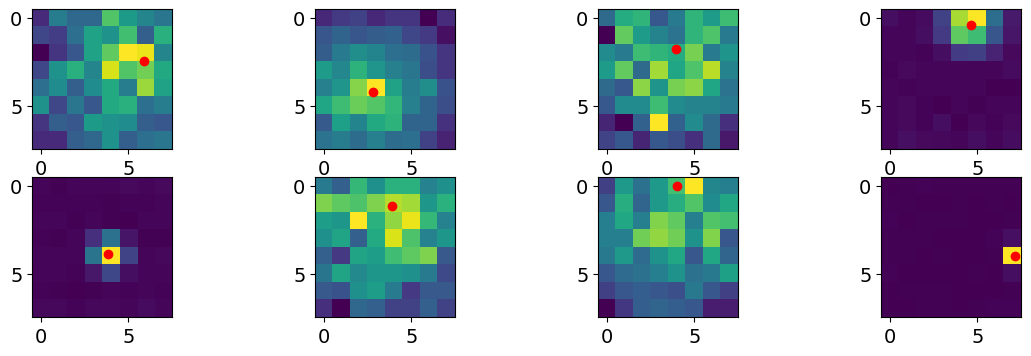

In [14]:
plot_images(imgs, mdata, range(0,8))

In [15]:
imgs[0]

array([[12., 22., 19., 19., 32., 26., 23., 21.],
       [15., 14., 20., 27., 25., 31., 18., 29.],
       [ 8., 13., 17., 27., 33., 41., 40., 23.],
       [15., 25., 29., 23., 39., 32., 34., 28.],
       [20., 24., 18., 24., 28., 22., 36., 27.],
       [25., 15., 21., 17., 28., 29., 20., 22.],
       [13., 18., 17., 26., 25., 24., 18., 17.],
       [12., 12., 18., 19., 25., 18., 20., 21.]], dtype=float32)

In [16]:
np.mean(imgs[0])

22.796875

In [17]:
np.std(imgs[0])

7.0802975

In [18]:
energy = get_energy(crystal, 9)

Selected files: img = images_9.npy, metdata = metadata_9.csv


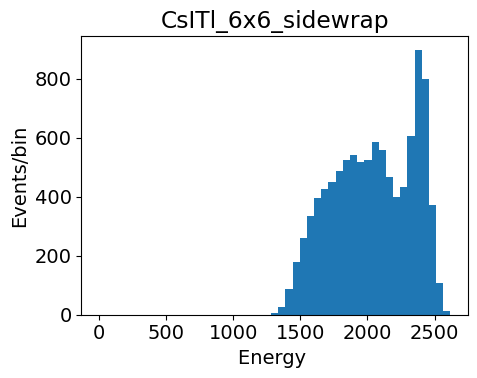

In [19]:
plot_energies2({"CsITl_6x6_sidewrap":energy}, xmin=0, xmax=max(energy),num_bins = 50)

In [20]:
mean6x6, std6x6, fwhm6x6 = mean_rms(energy)

print(f"mean = {mean6x6:.2f} resolution (FWHM)  = {100*fwhm6x6:.2f} %")

mean = 2040.97 resolution (FWHM)  = 33.80 %


In [76]:
class FF(nn.Module):
    def __init__(self, dropout=False, dropout_fraction=0.2):
        # call constructor from superclass
        super().__init__()

        self.dropout = dropout
        self.drop1 = nn.Dropout(p=dropout_fraction)
        # define network layers
        self.fc1 = nn.Linear(4, 4)
        self.fc2 = nn.Linear(4, 4)
        #self.fc3 = nn.Linear(4, 2)
        self.fc4 = nn.Linear(4, 1)
        
    def forward(self, x):
        # define forward pass
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        #x = torch.sigmoid(self.fc3(x))
        if self.dropout: x = self.drop1(x)
        x = torch.sigmoid(self.fc4(x))
        return x

In [77]:
ffmodel = FF(dropout=True).to(device)
print(ffmodel)
optimizer = optim.Adam(ffmodel.parameters(), lr=0.001)
criterion = nn.MSELoss()

FF(
  (drop1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=4, out_features=4, bias=True)
  (fc2): Linear(in_features=4, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=1, bias=True)
)


In [78]:
class FFMonoDataset(Dataset):
    """
    Loads the data to pytorch 
    self.dataset ->[d1, d2...] where di ->[(x,y,z,eobs), vector (etrue)]
    
    """

    def __init__(self, data_path: str, frst_file: int, lst_file: int,
                norm=False, xnorm=(24.0, 12.5, 35.3, 4700.0)):

        def normz(z):
            return (z - xnorm[1])/(xnorm[2] - xnorm[1])
            
        self.dataset = []
        img_name, lbl_name, indx = files_list_npy_csv(data_path)
        print(f"Loading files with indexes: {indx[frst_file:lst_file]}")

        ii = 0
        for i in indx[frst_file:lst_file]:
            images = np.load(f'{data_path}/{img_name}_{i}.npy')
            metadata = pd.read_csv(f'{data_path}/{lbl_name}_{i}.csv')
            
            for img, meta in zip(images, metadata.values):
                #ii=+1
                #print(f"img = {img}, sum = {np.sum(img)}")
                #print(f"meta = {meta}")
                xx = np.array([meta[1], meta[2], meta[3], np.sum(img)])
                yy = np.array(meta[4])

                if norm:
                    xx = np.array([meta[1]/xnorm[0], meta[2]/xnorm[0], normz(meta[3]), 
                                   np.sum(img/xnorm[3])])
                    yy = np.array(meta[4]/xnorm[3]) 
                self.dataset.append((xx,yy))
                #if ii >3 : break

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        xyze, etrue = self.dataset[idx]
        #print(f"xyze ={xyze}, etrue={etrue}")
        xyze = torch.tensor(xyze, dtype=torch.float)
        etrue = torch.tensor(etrue, dtype=torch.float).unsqueeze(0)

        return xyze, etrue

In [80]:
crystal

'/Users/jjgomezcadenas/data/monolith/CsITl_6x6_sidewrap_25k_2MHzDC_PTFE_LUT_NX'

In [79]:
fdataset = FFMonoDataset(crystal, first_file, last_file)

Loading files with indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


IndexError: index 4 is out of bounds for axis 0 with size 4

## Data set

In [21]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2


In [23]:
dataset = MonoDataset(crystal, first_file, last_file)


Running Monoataset with norm = False, resize=False
Loading files with indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [24]:
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)

Loaded 1000000 events
 train size = 700000
 val size = 200000
 test size = 100000
 train indices = range(0, 700000)
 val indices = range(700000, 900000)
 test indices = range(900000, 1000000)
700000 training events (70.0%)
200000 validation events (20.0%)
100000 test events (10.0%)


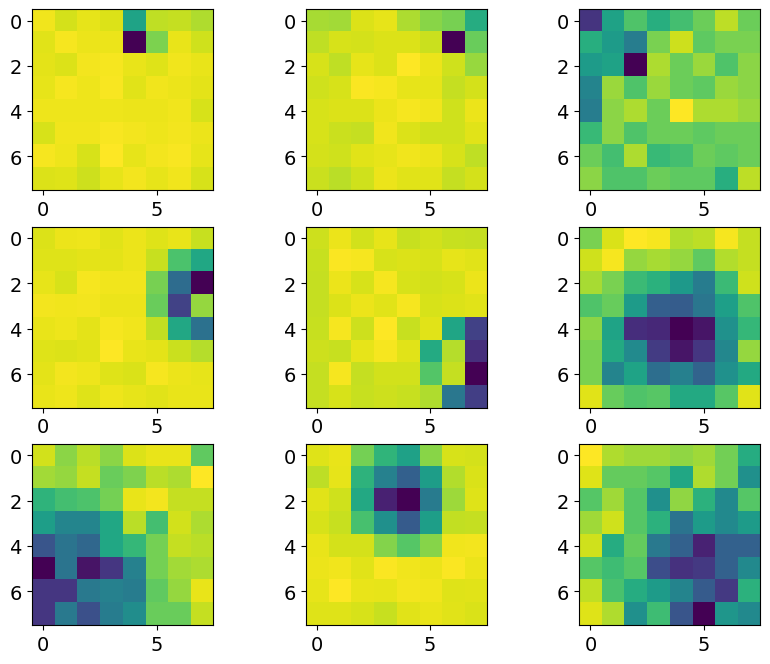

In [25]:
plot_images_ds(dataset, imgs=(0,9), sx=3, figsize=(10, 8))

In [26]:
for images, positions in train_loader:
    print(images.size())
    print(positions.size())
    print(images[0,0,:,:])
    break

torch.Size([1000, 1, 8, 8])
torch.Size([1000, 3])
tensor([[13., 15., 12., 16., 28., 18., 20., 17.],
        [18., 20., 17., 18., 29., 29., 25., 17.],
        [19., 36., 26., 26., 29., 33., 28., 24.],
        [25., 27., 25., 27., 33., 25., 33., 27.],
        [30., 35., 43., 41., 41., 43., 40., 29.],
        [26., 48., 49., 50., 57., 37., 31., 38.],
        [30., 46., 45., 55., 53., 43., 36., 23.],
        [32., 36., 47., 48., 61., 37., 36., 32.]])


### Train the network with CNN_basic 

In [27]:
# Load the model.
model = CNN_3x3(dropout=False).to(device)
print(model)

CNN_3x3(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [28]:
# Set up the optimizer and loss function.
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()


In [29]:
single_run(train_loader, device, model, optimizer,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (8,8,64) =>torch.Size([1000, 1, 8, 8])
(8,8,64) => (4,4,128) =>torch.Size([1000, 64, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 128, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 256, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512, 1, 1])
torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 1/700, Loss: 482.2541198730469
i = 1
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 2/700, Loss: 417.63458251953125


In [30]:
epochs = 10

In [31]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=epochs, iprnt=200)

Training with  ->700000 images
size of train loader  ->700 images
Evaluating with  ->200000 images
size of eval loader  ->200 images
Running for epochs ->10

EPOCH 0
Train Step 200/700, Loss: 3.6287662982940674
Train Step 400/700, Loss: 2.9966061115264893
Train Step 600/700, Loss: 3.8068997859954834
Validation Step 200/200, Loss: 3.1347312927246094
--- EPOCH 0 AVG TRAIN LOSS: 9.814783098357065
--- EPOCH 0 AVG VAL LOSS: 3.0308209586143495

EPOCH 1
Train Step 200/700, Loss: 2.691387176513672
Train Step 400/700, Loss: 2.5929694175720215
Train Step 600/700, Loss: 3.1438560485839844
Validation Step 200/200, Loss: 2.840402603149414
--- EPOCH 1 AVG TRAIN LOSS: 2.842506071499416
--- EPOCH 1 AVG VAL LOSS: 2.7637605381011965

EPOCH 2
Train Step 200/700, Loss: 2.592054843902588
Train Step 400/700, Loss: 2.5898475646972656
Train Step 600/700, Loss: 2.307184934616089
Validation Step 200/200, Loss: 2.650239944458008
--- EPOCH 2 AVG TRAIN LOSS: 2.5837047008105687
--- EPOCH 2 AVG VAL LOSS: 2.480103648

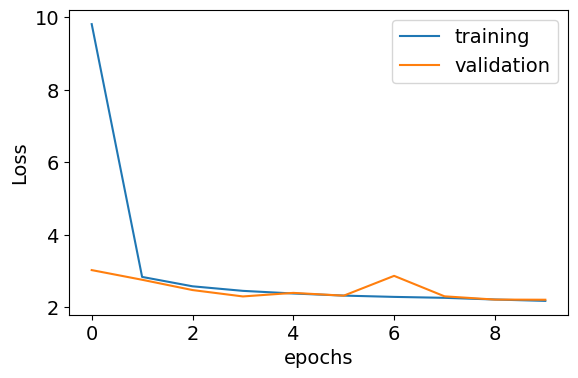

In [32]:
plot_loss(epochs, train_losses, val_losses,figsize=(6, 4))


In [33]:
tdeltas = evaluate_cnn(test_loader, model, device)

In [ ]:
#plot_true_predicted(tdeltas, nbins = 50)

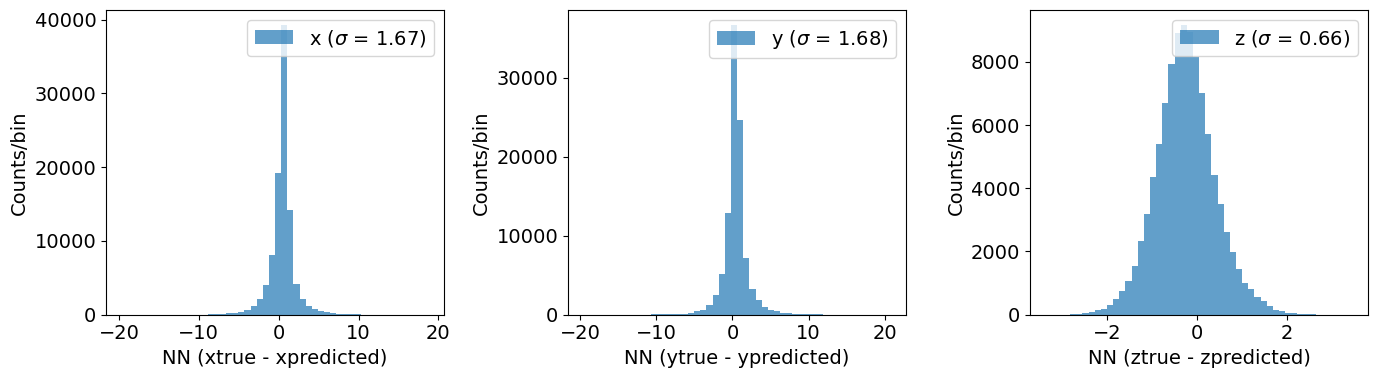

In [34]:
plotxyz(tdeltas, nbins=50)

## Normalize

In [64]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 1000  # Batch size
train_fraction=0.7 
val_fraction=0.2
mean=31.96
std=46.79

In [65]:
dataset = MonoDataset(crystal, 
                      first_file, last_file,
                      norm=True, resize=False, mean=18.6, std=5.0)


Running Monoataset with norm = True, resize=False
Loading files with indexes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98 99]


In [66]:
 data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   
    

Loaded 1000000 events
 train size = 700000
 val size = 200000
 test size = 100000
 train indices = range(0, 700000)
 val indices = range(700000, 900000)
 test indices = range(900000, 1000000)
700000 training events (70.0%)
200000 validation events (20.0%)
100000 test events (10.0%)


In [67]:
model = CNN_3x3(dropout=True).to(device)
print(model)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

CNN_3x3(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc0): Linear(in_features=512, out_features=3, bias=True)
  (drop1): Dropout(p=0.2, inplace=False)
)


In [68]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size, epochs=20, iprnt=300)

Training with  ->700000 images
size of train loader  ->700 images
Evaluating with  ->200000 images
size of eval loader  ->200 images
Running for epochs ->20

EPOCH 0
input data shape =>torch.Size([1000, 1, 8, 8])
(8,8,1) => (8,8,64) =>torch.Size([1000, 1, 8, 8])
(8,8,64) => (4,4,128) =>torch.Size([1000, 64, 4, 4])
(4,4,128) => (2,2,256) =>torch.Size([1000, 128, 2, 2])
(2,2,256) => (1,1,512) =>torch.Size([1000, 256, 1, 1])
(1,1,512) => (1,1,3) =>torch.Size([1000, 512, 1, 1])
torch.Size([1000, 3])
Train Step 300/700, Loss: 4.019372463226318
Train Step 600/700, Loss: 4.329400539398193
--- EPOCH 0 AVG TRAIN LOSS: 12.43726593869073
--- EPOCH 0 AVG VAL LOSS: 2.744958071708679

EPOCH 1
Train Step 300/700, Loss: 3.854404926300049
Train Step 600/700, Loss: 3.8391337394714355
--- EPOCH 1 AVG TRAIN LOSS: 3.5634585424831937
--- EPOCH 1 AVG VAL LOSS: 2.5674676942825316

EPOCH 2
Train Step 300/700, Loss: 3.4705116748809814
Train Step 600/700, Loss: 3.4360551834106445
--- EPOCH 2 AVG TRAIN LOSS: 3.30

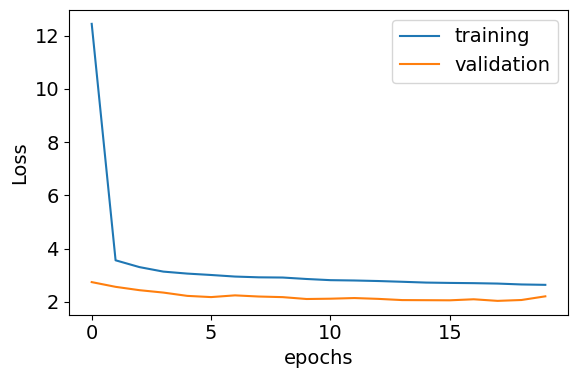

In [69]:
plot_loss(20, train_losses, val_losses,figsize=(6, 4))


In [70]:
tdeltas = evaluate_cnn(test_loader, model, device, pixel_size = 6)


In [43]:
tdeltas

tdeltas(delta_x_NN=array([ 0.1393261 ,  1.8845863 ,  0.18439293, ...,  1.0216169 ,
       -0.15976563, -2.7006035 ], dtype=float32), delta_y_NN=array([-0.4495182 , -1.6660283 , -0.07518744, ..., -0.5979414 ,
       -0.27518404,  0.68653345], dtype=float32), delta_z_NN=array([-0.10061646, -0.14482498, -0.777771  , ...,  0.7169075 ,
       -0.38318443, -0.27913475], dtype=float32), delta_x_classical=0.0, delta_y_classical=0.0)

In [ ]:
tdeltas.delta_z_NN

In [ ]:
np.save("/Users/jjgomezcadenas/Projects/pymono/notebooks/delta_z_cnn_bgo.npy", tdeltas.delta_z_NN)

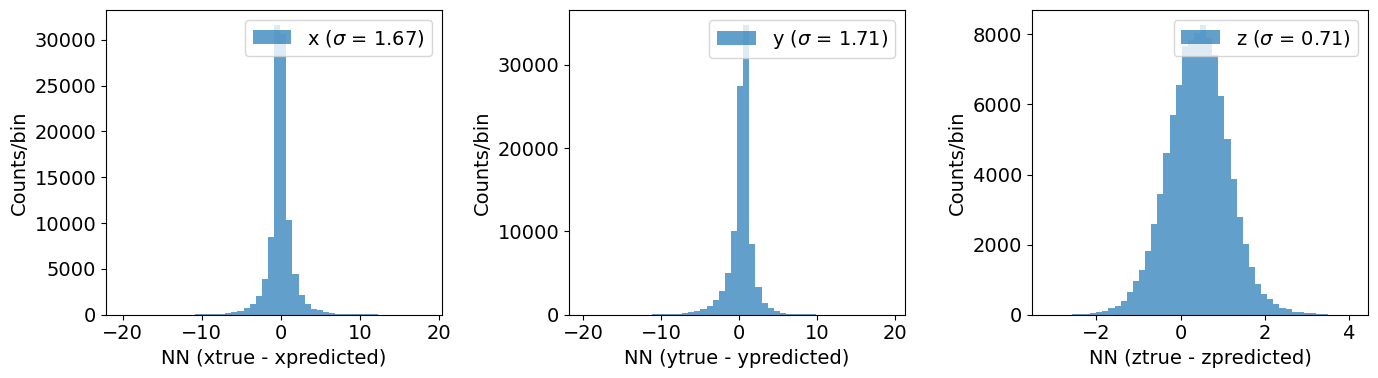

In [71]:
plotxyz(tdeltas, nbins=50)

### Deeper network

In [45]:
class ResBlock(nn.Module):
    """
    Implements a residual block consisting in [Conv2d->BatchNorm2d->ReLU] + 
    [Conv2d->BatchNorm2d]. This residual is added to the input (then a second activation ReLU applied)
    
    If downsample = None (e.g, default first pass), then we obtain f(x) + x where 
    f(x) -> [Conv2d->BatchNorm2d->ReLU ->Conv2d->BatchNorm2d]. Otherwise the block is skipped. 
    
    """
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, 
                                  stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, 
                                  stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x # This is the residual (in the case of no downsample)
        out = self.conv1(x)
        out = self.conv2(out)
        
        if self.downsample:  # this is the residual in the case of downsample
            residual = self.downsample(x)
            
        out += residual # This is it! f(x) + x 
        out = self.relu(out)

        return out

In [46]:
class ResNet10(nn.Module):
    """
    Implements the Residual Network with 34 layers:
    The architecture is like this:
    1. Image passes through a convolution (kernel 3x3) 
    with stride = 1 and padding = 1 which increases the features from 3 to 64 and 
    preserves spatian dimensions, then batch normalization and activation. 
    # (W,H,1) => (W,H,64)
    
    2. The layer architecture is as follows (with a skip connection between each pair of layers) 
        6 layers of convolution 3x3 with 64 features
        8 layers of convolution 3x3 with 128 features (max pool 56 -> 28)
        12 layers of convolution 3x3 with 256 features (max pool 28 -> 24)
        6 layers of convolution 3x3 with 512 features (max pool 14 -> 7)
    3. Then avgpool and fc.
    
    """
    def __init__(self, block, num_classes = 3, dropout=False, dropout_fraction=0.2, debug=False):
        super(ResNet10, self).__init__()
        self.debug = debug
        self.inplanes = 64

        self.conv1 = nn.Sequential(
                        nn.Conv2d(1, 64, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(2, 2)
        self.layer0 = self._make_layer(block, 64, 1, stride = 1, nlyr = 1)
        self.layer1 = self._make_layer(block, 128, 1, stride = 2, nlyr = 2)
        self.layer2 = self._make_layer(block, 256, 1, stride = 2, nlyr = 3)
        self.layer3 = self._make_layer(block, 512, 1, stride = 2, nlyr = 4)
        self.avgpool = nn.AvgPool2d(1, stride=1)
        self.fc = nn.Linear(512, num_classes)
        self.dropout = dropout
        self.drop1 = nn.Dropout(p=dropout_fraction)

           
    def _make_layer(self, block, planes, blocks, stride, nlyr):
        downsample = None
        
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        if self.debug:
            print(f" ## make_layer {nlyr}: planes = {planes},  blocks = {blocks}, stride = {stride}")
            print(f" ## make_layer: in_planes={self.inplanes}")
            print(f" ## make_layer: downsample = {downsample}")
            #print(f"layer block = 0: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = {stride}, downsample = {downsample}")
            
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
            if self.debug:
                print(f" layer block = {i}: Block(in_channels={self.inplanes}, out_channels ={planes}, stride = 1, downsample = None")

        return nn.Sequential(*layers)
    
    def forward(self, x):
        if(self.debug): print(f" ResNet10: input data shape =>{x.shape}")
            
        x = self.conv1(x)
        if(self.debug): print(f" ResNet10: after conv1 =>{x.shape}")
            
        #x = self.maxpool(x)
        #if(self.debug): print(f" ResNet: after maxpool =>{x.shape}")
            
        x = self.layer0(x)
        if(self.debug): print(f" ResNet10: after layer0 =>{x.shape}")
        
        x = self.layer1(x)
        if(self.debug): print(f" ResNet10: after layer1 =>{x.shape}")
            
        x = self.layer2(x)
        if(self.debug): print(f" ResNet10: after layer2 =>{x.shape}")
            
        x = self.layer3(x)
        if(self.debug): print(f" ResNet10: after layer3 =>{x.shape}")
            
        x = self.avgpool(x)
        if(self.debug): print(f" ResNet10: after avgpool =>{x.shape}")

        x = x.flatten(start_dim=1)
        #x = x.view(x.size(0), -1)
        if(self.debug): print(f" ResNet10: after flatten =>{x.shape}")
        
        if self.dropout: x = self.drop1(x)  # drop
        x = self.fc(x)
        if(self.debug): print(f" ResNet10: after fc =>{x.shape}")

        self.debug = False
        return x
  

In [47]:
#define the model
model = ResNet10(ResBlock, debug=True).to(device)

 ## make_layer 1: planes = 64,  blocks = 1, stride = 1
 ## make_layer: in_planes=64
 ## make_layer: downsample = None
 ## make_layer 2: planes = 128,  blocks = 1, stride = 2
 ## make_layer: in_planes=64
 ## make_layer: downsample = Sequential(
  (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 3: planes = 256,  blocks = 1, stride = 2
 ## make_layer: in_planes=128
 ## make_layer: downsample = Sequential(
  (0): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
 ## make_layer 4: planes = 512,  blocks = 1, stride = 2
 ## make_layer: in_planes=256
 ## make_layer: downsample = Sequential(
  (0): Conv2d(256, 512, kernel_size=(1, 1), stride=(2, 2))
  (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)


In [48]:
print(model)

ResNet10(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
    )
  )
  (layer1): Sequential(
    (0): ResBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-0

In [49]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [50]:
single_run(train_loader, device, model, optimizer,criterion)

** Run for 1 event**
epoch = 0
i = 0
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
 ResNet10: input data shape =>torch.Size([1000, 1, 8, 8])
 ResNet10: after conv1 =>torch.Size([1000, 64, 8, 8])
 ResNet10: after layer0 =>torch.Size([1000, 64, 8, 8])
 ResNet10: after layer1 =>torch.Size([1000, 128, 4, 4])
 ResNet10: after layer2 =>torch.Size([1000, 256, 2, 2])
 ResNet10: after layer3 =>torch.Size([1000, 512, 1, 1])
 ResNet10: after avgpool =>torch.Size([1000, 512, 1, 1])
 ResNet10: after flatten =>torch.Size([1000, 512])
 ResNet10: after fc =>torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 1/700, Loss: 481.72296142578125
i = 1
images = torch.Size([1000, 1, 8, 8])
labels = torch.Size([1000, 3])
outputs = torch.Size([1000, 3])
Train Step 2/700, Loss: 433.14453125


In [51]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size=500, epochs=10, iprnt=200)

Training with  ->350000 images
size of train loader  ->700 images
Evaluating with  ->100000 images
size of eval loader  ->200 images
Running for epochs ->10

EPOCH 0
Train Step 200/700, Loss: 3.341529369354248
Train Step 400/700, Loss: 2.516585350036621
Train Step 600/700, Loss: 2.6503841876983643


KeyboardInterrupt: 

In [ ]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))


In [ ]:
plotxyz(tdeltas, nbins=50)

In [ ]:
first_file = 0  # initial file indx
last_file  = 100  # lasta file indx
batch_size = 250  # Batch size
train_fraction=0.7 
val_fraction=0.2
dataset = MonoDataset(CsI_6x6_fullwrap_50k_0MHzDC_PTFE_LUT_NX, 
                      first_file, last_file,
                      norm=True, resize=False, mean=165.90, std=93.3)
data_loader, train_loader, val_loader, test_loader = mono_data_loader(dataset, 
                                                                      batch_size=batch_size, 
                                                                      train_fraction=train_fraction, 
                                                                      val_fraction=val_fraction)   


In [ ]:
model = ResNet10(ResBlock, debug=False, dropout=True, dropout_fraction=0.2).to(device)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [ ]:
train_losses, val_losses = train_cnn(train_loader, val_loader,
                                    model, optimizer, device, criterion, 
                                    batch_size=batch_size, epochs=10, iprnt=400)

In [ ]:
plot_loss(10, train_losses, val_losses,figsize=(6, 4))


In [ ]:
tdeltas = evaluate_cnn(test_loader, model, device)
plotxyz(tdeltas, nbins=50)

## Calculation of means

In [52]:
means, stds = get_means_stds(dir=crystal)

files in dir: 100
shape -> (10000, 8, 8)
mean img0 =31.453125
std  img0 =35.80194091796875


In [53]:
len(means)

100

In [54]:
means[0][0]

38.109375

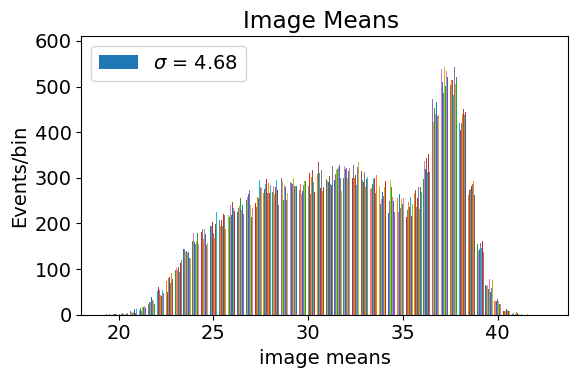

In [55]:
histoplot(means, "image means", vart="Image Means ", num_bins = 50, figsize=(6, 4))

In [56]:
meansx =[np.mean(x) for x in means]

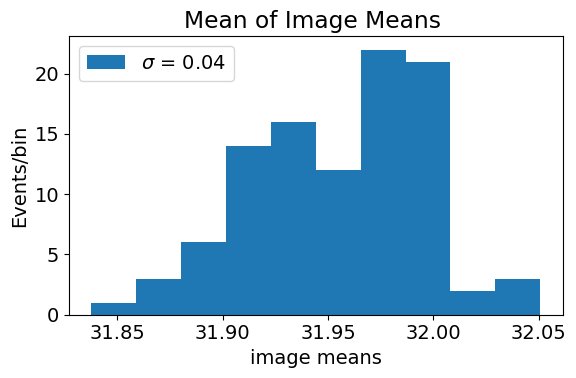

In [57]:
histoplot(meansx, "image means", vart="Mean of Image Means ", num_bins = 10, figsize=(6, 4))

In [59]:
np.mean(meansx)

31.956604

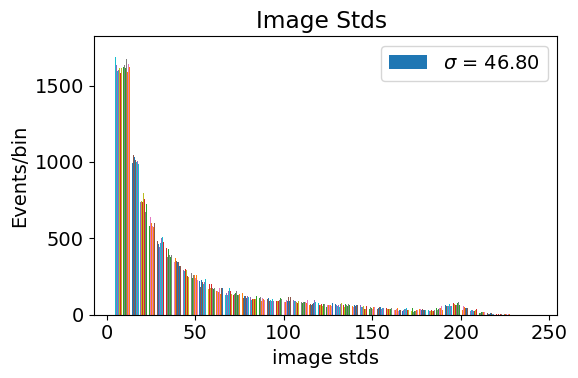

In [60]:
histoplot(stds, "image stds", vart="Image Stds ", num_bins = 50, figsize=(6, 4))

In [61]:
stdsx =[np.std(x) for x in stds]

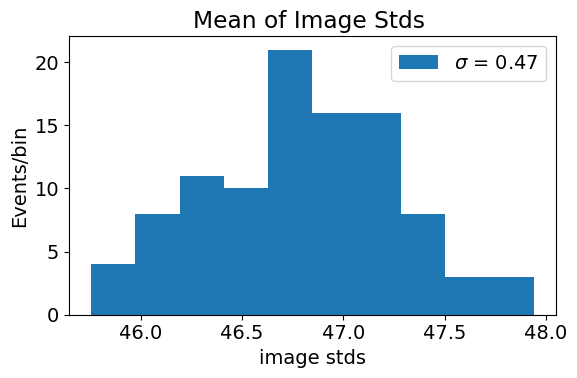

In [62]:
histoplot(stdsx, "image stds", vart="Mean of Image Stds ", num_bins = 10, figsize=(6, 4))

In [63]:
np.mean(stdsx)

46.79459